<title>Описание задачи</title>
 <h1>Описание задачи</h1>
 <p>Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.</p>
 <p>Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными.</p>
 <p>Цель исследования: найти факторы влияющие на успех игры</p>
 <h2>Ход исследования:</h2>
 <ol>
  <li>Предобработка данных</li>
  <li>Исследовательский анализ</li>
  <li>Проверка гипотез</li>
 </ol>
 
</body>

In [9]:
# импорты
from dotenv import load_dotenv
from http import HTTPStatus
import os.path
import pandas as pd
import re
import requests
from scipy import stats as st
import seaborn as sns
import sys
import logging
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [10]:
# настроимся на приятный вечер
load_dotenv()
# зачем себя лишний раз расстраивать?
warnings.filterwarnings('ignore')

# баги - вечный леденец - соси его хоть круглый год, меньше не станет,
# но нужно их отлавливать, если я вдруг забуду поменяй, пожалуйста, level,
# должен быть - level=logging.INFO 
#logging.DEBUG - just for me

logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO)

# будем следить за поведением программы и за пользователями
# с помощью кастомного исключения на все случаи жизни
class BaseException(Exception):
    """Напишем базовое исключение"""

    def __init__(self, text):
        """активация..."""
        self.text = text


<h2>Предобработка данных</h2>
 <p>Предобработка данных не самый увлекательный процесс, однако у нас есть очень подробное тз, так что можно и сделать процесс увлекательным и забавным.</p>
 <p>Идея в том, что, если известно качество данных не будем тянуть кота за хвост, а зафигачим все обработку в одну функцию.</p>
 <p>Отмечу, такое возможно, только благодаря супер разжёванному тз.</p>
 <h1>Имена колонок</h1>
 <p>В ТЗ написано, что с названиями колонок нечисто, в конце есть даже все имена колонок, но это портит все веселье.</p>
 <p>Для проверки корректности наименований напишем функцию, которая неправильные колонки соберет в список и отдаст нам.</p>
 <p>Так как нам известно, что именно в наименованиях неправильно проблемку легко решить, сделаем это! – Напишем функцию, которая заберет неправильные имена колонок из списка и подставит их в словарь, с правильными наименованиями. Этот словарь мы передадим по эстафете и переименуем колонки.</p>
 <p>ОТ АВТОРА можно и проще, например df.columns = df.columns.str.lowerd - но только хардкор и высокий уровень абстракции!!!! -> глобально, могло быть такое, что не все имена колонок надо менять.</p>
  <h1>Пропуски</h1>
 <p>Поищем пропуски и соберем их в словарь. На прошлом проекте мы договорились, что, если пропуски занимают менее пяти процентов, то их выкидываем без сожаления, так и поступим.</p>
 <p>На столбцы, где пропусков больше поставим заглушки. Я считаю, это оправдано, ведь если мы начнем сочинять отзывы пользователей или критиков - это, вроде как, антидемократично 😊</p>
 <p>Из задания известно об аномалии tdb – заменяем на заглушку – если хочется узнать, что за штука стоит спросить у источника данных.</p>
 <p>Изменим тип данных у года выпуска – на datetime и, спасибо tdb, приведем оценку пользователя на число с плавающей точкой.</p>
 <p>А, ну и столбец зафигачим.</p>

In [11]:
PATH_ERROR_TEXT = 'некоррекнто прописан путь к данным'
def read_file(path_1: str, path_2: str) -> pd.DataFrame:
    """
    Функция считывает данные из файла и
    возвращает дата фрейм
    """
    # проверим, что файл существует, также стоит проверить
    # что это именно файл, если это не так, то нет смысла продолжать
    if os.path.exists(path_1) and os.path.isfile(path_1) or requests.get(path_1).status_code == HTTPStatus.OK:
        logging.info('works online')
        data = pd.read_csv(path_1)
        logging.info('read file sucsess')
        return data
    elif os.path.exists(path_2) and os.path.isfile(path_2):
        logging.info('works lokaly')
        data = pd.read_csv(path_2)
        logging.info('read file sucsess')
        return data
    else:
        logging.critical(PATH_ERROR_TEXT)
        raise BaseException(PATH_ERROR_TEXT) and sys.exit()


def get_full_information(data):
    """
    Функция дает нам полное
    представление о данных
    """
    for _ in [data.head(), data.describe(), data.info()]:
        display(_)
    data.hist(figsize=(15, 10))
    plt.show();


def check_names_columns(data: pd.DataFrame) -> list[str]:
    """
    Функция проверяет, соответствуют
    ли имена колонок snake_style
    """
    columns_to_change = []
    pattern = r"^[a-z]+(_[a-z]+)*$"
    for column in data.columns:
        match = re.match(pattern, column)
        if match:
            continue
        else:
            columns_to_change.append(column)
    logging.debug(columns_to_change)
    return columns_to_change


NOT_LIST = 'входные данные должны быть в форме списка'
NOT_STR = 'в списке должны быть строки'
def change_name_columns(columns_to_change: list) -> list[str]:
    """
    Функция возвращает словарь,
    ключ- неправильное название колонки
    значение - верное
    """
    right_names = []
    # проверим, что нам подсунули на входе,
    # это нужно, для обеспечения устойчивости программы
    if not isinstance(columns_to_change, list):
        raise BaseException(NOT_LIST)
    for column in columns_to_change:
        if not isinstance(column, str):
            raise BaseException(NOT_STR)
    else:
        for column in columns_to_change:
            column = column.lower()
            right_names.append(column)
    columns = {c:r for c,r in zip(columns_to_change, right_names)}
    logging.debug(columns)
    return columns


def find_nan(data: pd.DataFrame) -> dict:
    """
    Функция считает по каждой колонке, сколько в ней пропусков,
    если пропусков 0, то с колонкой все хорошо
    и ее мы трогать не будем
    """
    return {column: data[column].isna().sum()/len(data)
            for column in data.columns
            if data[column].isna().sum() != 0}


def drop_nan_less_five_percent(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция удаляет строки по колонкам,
    если кол-во пропусков в них составляло
    менее 5 процентов
    """
    columns_with_nan = find_nan(data)
    for column, percent in columns_with_nan.items():
        if percent < .05:
            data = data[data[column].notna()]
    return data


def works_dupblicates(data: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Функция работает с дубликатами
    """
    # приведем значения колонок к нижнему регистру
    for column in columns:
        data[column] = data[column].str.lower()
    # если появились дубликаты дропнем их
    if data.duplicated().sum() > 0:
        data = data.drop_duplicates()
    else:
        return data


def process_data()->pd.DataFrame:
    """
    Функция содержит основную логику
    первичной обработки данных
    """
    try:
        # читаем данные и выводим всю правду о них
        data = read_file(os.getenv('ppo', ''),'games.csv')
        get_full_information(data)

        # работаем с названиями колонок
        columns_to_change = check_names_columns(data)
        if len(columns_to_change) > 0:
            columns_with_correct_name = change_name_columns(columns_to_change)
            data = data.rename(columns=columns_with_correct_name)


        # поработаем с пропусками
        logging.debug(data['platform'].unique())
        logging.debug(find_nan(data))
        data = drop_nan_less_five_percent(data)
        logging.debug(find_nan(data))

        # поставим заглушки на пропуски по оценкам
        for column in ['user_score', 'critic_score']:
            data.loc[(data[column].isna()), column] = -1

        # уничтожаем дубликаты
        data = works_dupblicates(data, ['name','platform', 'genre', 'rating'])

        # по заданию обрабатываем непонятную штучку tbd - я то откуда знаю, что это за дичь???
        data.loc[(data['user_score'] == 'tbd'), 'user_score'] = -1
        data.loc[(data['rating'].isna(), 'rating')] = 'unknown'

        # приводим к нужным типам, хотел зафигачить функцию, но кажется игра не стоит свечь
        data['year_of_release'] = pd.to_datetime(data['year_of_release'].astype(int).astype(str), format='%Y').dt.year
        data['user_score'] = data['user_score'].astype(float)

        # определим общие продажи
        data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
        if 'total_sales' not in set(data.columns):
            raise BaseException('total_sales does not exsist?!')

        # фуххх, добрались до конца
        logging.info('выдыхай, бобер, первичная обработка данных окончена')
        return data

    # если были ошибки, не стоит их скрывать, скажем об этом прямо
    except BaseException as error_message:
        return(error_message)


2024-05-02 23:27:32,675 - INFO - works online


2024-05-02 23:27:33,972 - INFO - read file sucsess


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


None

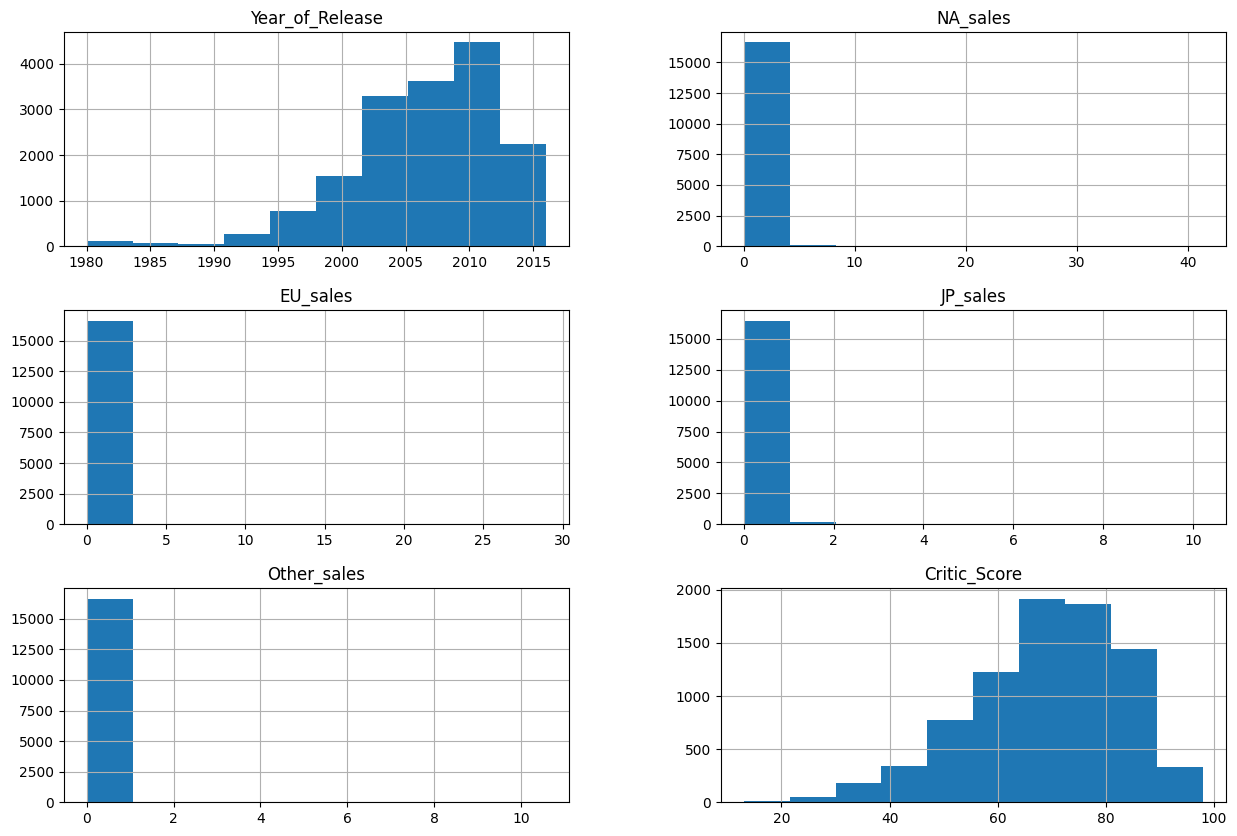

2024-05-02 23:27:35,340 - INFO - выдыхай, бобер, первичная обработка данных окончена


In [12]:
# обрабатываем данные
data = process_data()


In [13]:
data['rating'].value_counts()

rating
unknown    6676
e          3921
t          2905
m          1536
e10+       1393
ec            8
k-a           3
ao            1
rp            1
Name: count, dtype: int64

<p>Пропуски могут быть вызванны несколькими причинами: Технический сбой (неправильная выгрузка данных) Человеческий фактор (неправильное заполнение полей формы)</p>
<p>Пользователи и критики могли не предоставить данные. Возможно, эту информацию не требуют в некоторых случаях. Проблемы могли возникнуть на этапе загрузки и на этапе выгрузки данных. Неправильный запрос, объединение таблиц также может быть причиной.</p>

<h1>Исследовательский анализ</h1>

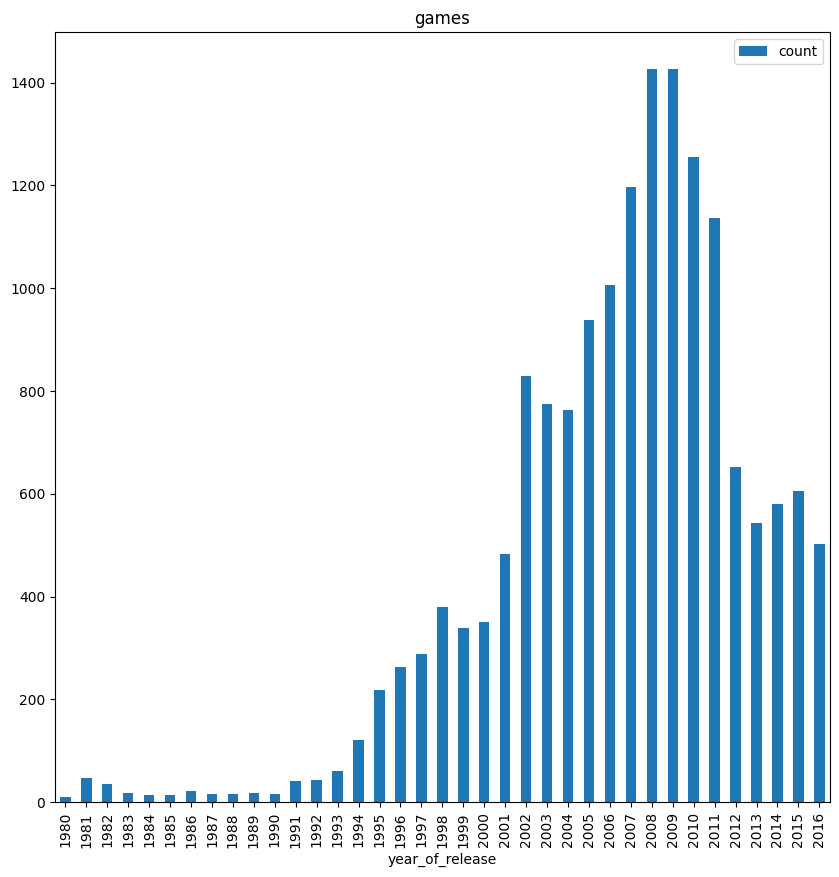

In [14]:
# Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды? -> хз

#Строим умную табличку и график к ней прилагается
p_t = data.pivot_table(index='year_of_release',
                       values='name',
                       aggfunc='count')
p_t.columns = ['count']
p_t.plot(kind='bar',
         figsize=(10,10),
         title='games');


Ну, скорее всего, дынные за весь период не нужны. По картинке видно, что с 2005 – 2012 индустрия пережила бум, однако теперь все идет, куда идет.

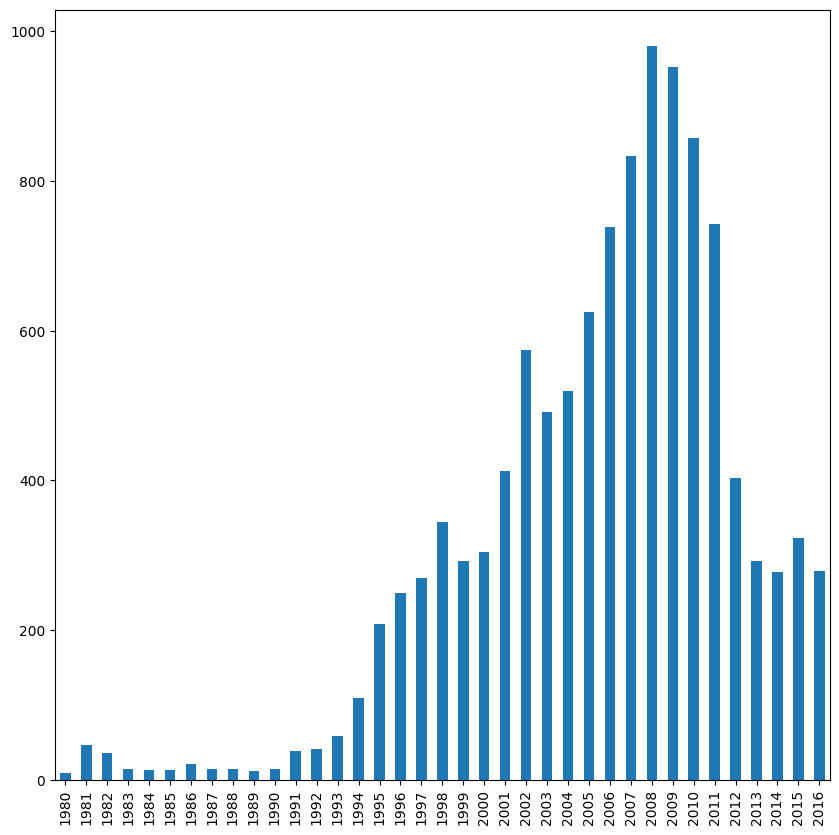

In [15]:
def find_first_relese(df):
    if 'name' not in set(df.columns):
        raise BaseException('platform must be in columns!')
    first_relese_sup = {}
    for _ in range(0,len(df)):
        if first_relese_sup.get(df['name'][_]) == None:
            first_relese_sup[df['name'][_]] = [df['year_of_release'][_]]
        else:
            first_relese_sup[df['name'][_]].append(df['year_of_release'][_])
    logging.debug(first_relese_sup)
    first_relese = {}
    for name, year in first_relese_sup.items():
        first_relese[name] =  min(year)
    return first_relese
df = data.loc[:,['name','year_of_release']].reset_index()

first_relese={}

for year in find_first_relese(df).values():
    if first_relese.get(year) == None:
        first_relese[year] = 1
    else:
        first_relese[year] += 1
    
pd.Series(dict(sorted(first_relese.items(), key=lambda x: x[0]))).plot(kind='bar', figsize=(10,10))
plt.show();



2024-05-02 23:27:36,810 - INFO - ['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps', 'ps4', 'gba', 'psp', '3ds']


2024-05-02 23:27:37,371 - INFO - 8.612903225806452
2024-05-02 23:27:37,372 - INFO - 7.0


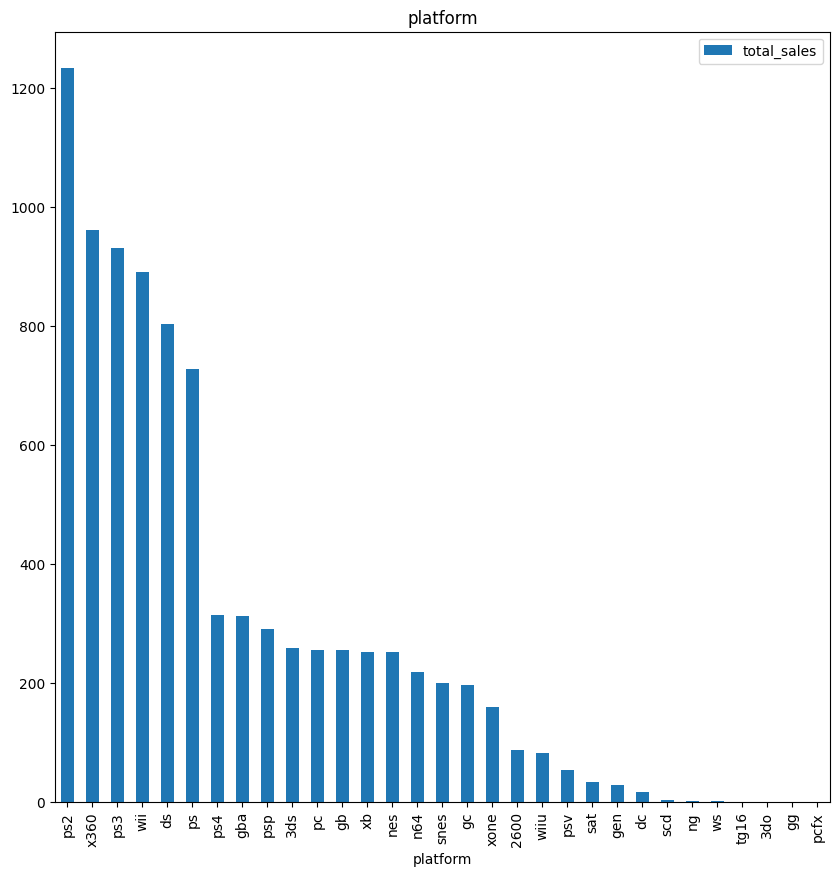

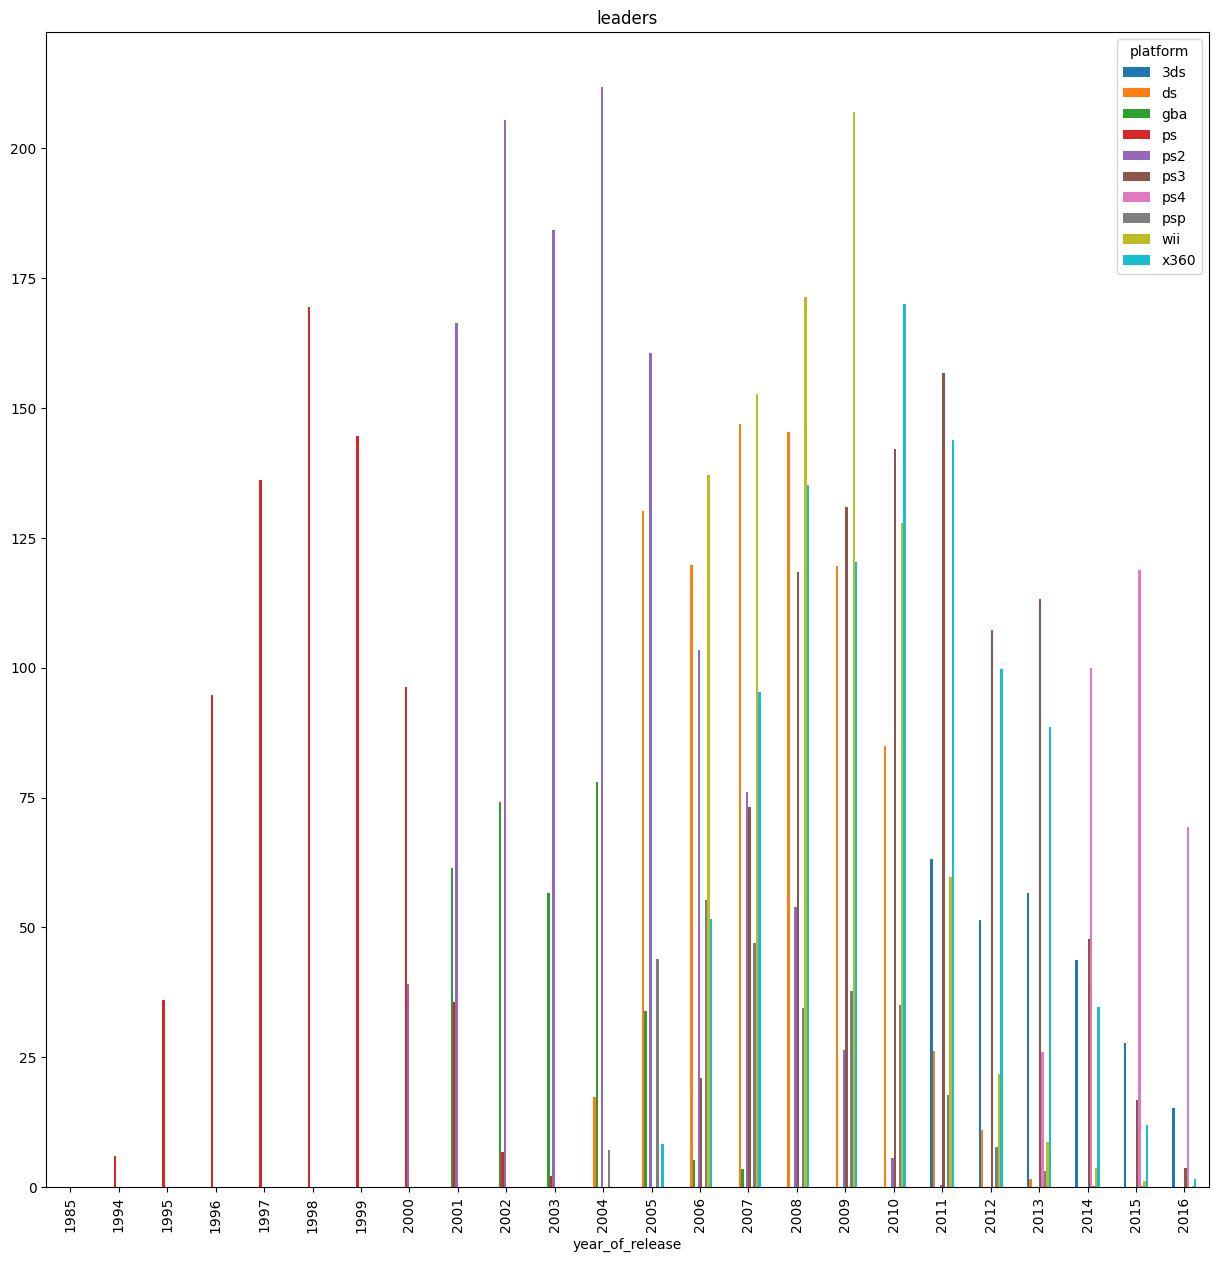

In [16]:
# Посмотрите, как менялись продажи по платформам.
# Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам.
# За какой характерный срок появляются новые и исчезают старые платформы?

# сделаем табличку и построим диаграмму
p_t = data.pivot_table(index='platform',
                           values='total_sales',
                           aggfunc='sum')
p_t.columns = ['total_sales']
p_t = p_t.sort_values(by='total_sales', 
                      ascending=False)
p_t.plot(kind='bar',
         figsize=(10,10),
         title='platform');

# узнаем лидеров в лицо и сохраним в список
leaders = list(p_t.head(10).index)
logging.info(leaders)

# построим табличку по лидерам
leaders_table = data.query('platform in @leaders')
leaders_table = leaders_table.pivot_table(index='year_of_release',
                                          columns='platform',
                                          values='total_sales',
                                          aggfunc='sum')
leaders_table.plot(kind='bar',
                   figsize=(15,15),
                   title='leaders');


# Узнаем сколько живет платформа
def calculate_live_cicle_platform(df: pd.DataFrame) -> dict:
    """
    Функция возвращает словарь:
    ключ - наименование платформы,
    значение - кол-во лет существования фирмы
    """
    if 'platform' not in set(df.columns):
        raise BaseException('platform must be in columns!')
    platforms_live_cicle_sup = {}
    for _ in range(0,len(df)):
        if platforms_live_cicle_sup.get(df['platform'][_]) == None:
            platforms_live_cicle_sup[df['platform'][_]] = [df['year_of_release'][_]]
        else:
            platforms_live_cicle_sup[df['platform'][_]].append(df['year_of_release'][_])
    platforms_live_cicle = {}
    for platform, years in platforms_live_cicle_sup.items():
        platforms_live_cicle[platform] = (max(years) - min(years)) + 1
    return platforms_live_cicle

df = data.loc[:,['platform','year_of_release']].reset_index()
platform_live_cicle = pd.Series(calculate_live_cicle_platform(df))

# сохраним длительность жизни в переменную
mean_platform_live_cicle = platform_live_cicle.mean()
median_platform_live_cicle = platform_live_cicle.median()
logging.info(mean_platform_live_cicle)
logging.info(median_platform_live_cicle)


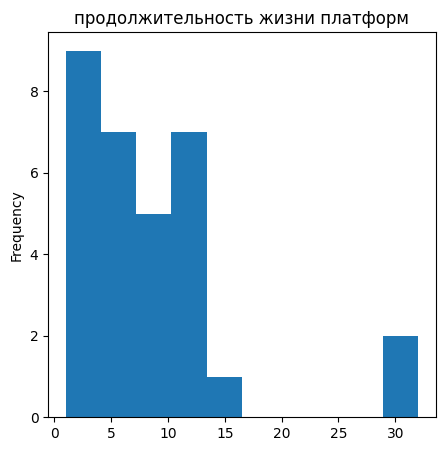

In [17]:
# Посмотрим на картинке жизненный цикл

platform_live_cicle.plot(kind='hist',
                        figsize=(5,5),
                        title='продолжительность жизни платформ');


Из графиков видно, что в индустрии есть свои гиганты, которые занимают большую часть рынка, у них то дела идут хорошо в любой период. Средняя продолжительность жизни платформы – 8.6 лет, а медианная – 7, похоже, разброс данных небольшой и данные хорошие

2024-05-02 23:27:39,056 - INFO - 11.5


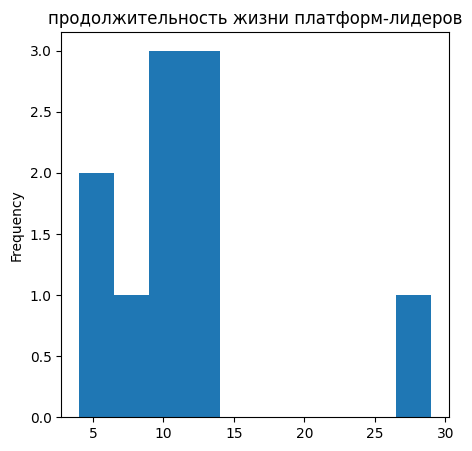

In [18]:
df = data.query('platform in @leaders').loc[:,['platform','year_of_release']].reset_index()
leaders_platform_live_cicle = pd.Series(calculate_live_cicle_platform(df))
mean_leaders_platform_live_cicle = leaders_platform_live_cicle.mean()
logging.info(mean_leaders_platform_live_cicle)
leaders_platform_live_cicle.plot(kind='hist',
                        figsize=(5,5),
                        title='продолжительность жизни платформ-лидеров');


Определим актуальный период: предлагаю руководствоваться жизненным циклом платформы, будет обидно сделать ставку на ее игру, а она загнётся

In [19]:

a=data[['total_sales', 'year_of_release']].sort_values(by='year_of_release').reset_index()['total_sales'].to_list()
corr=[]
i=1
while i<= len(a)/4:
    corr.append(np.corrcoef(a[:-i], a[i:])[0, 1])
    i +=1
logging.debug(corr)
# вычисляем статистику t и p-value
t_stat, p_value = st.ttest_1samp(a, corr[corr.index(max(corr))])

# Если p-value меньше выбранного уровня значимости (обычно 0.05), то мы можем отвергнуть нулевую гипотезу о том, 
# что коэффициент автокорреляции равен нулю, и сделать вывод о наличии автокорреляции в данных.


print("Коэффициент автокорреляции", corr[corr.index(max(corr))])
print("Статистика t:", t_stat)
print("p-value:", p_value)
if p_value < 0.05:
    print('можно сделать вывод о наличии автокорреляции в данных')
    print(f'оптимальный период для анализа будет равен: {corr.index(max(corr))+1} лет')
else:
    print('данные не автокоррелированны, нет смысла выбирать оптимальный период для анализа')

Коэффициент автокорреляции 0.10311678133583925
Статистика t: 35.61324911280496
p-value: 1.1552557805511383e-267
можно сделать вывод о наличии автокорреляции в данных
оптимальный период для анализа будет равен: 9 лет


<div class = "alert alert-info" style="border-left: 7px solid blue">
<p>определение актуальность данных с целью построения прогноза является задачей исследования временного ряда - динамика общих продаж по годам.</p>  
<p>Как магазин продаж комп игр нас прежде всего интересует общие продажи и именно их следует прогнозировать
<p>При анализе временных рядов важное место занимает автокорреляция (зависимость значений уровней временного ряда от предыдущих (сдвиг на 1 уровень того же ряда)). Корреляционную зависимость между последовательными уровнями временного ряда называют автокорреляцией уровней ряда.</p> 
<p>Количественно ее можно измерить с помощью линейного коэффициента корреляции между уровнями исходного временного ряда и уровнями ряда, сдвинутыми на несколько шагов вперед.</p> 
<p>Величина сдвига, соответствующего наибольшему коэффициенту автокорреляции, называется временным лагом.</p> 
<p>Соответственно, чтобы отсеять неактуальные тренды нам небходимо попасть в наш временной лаг</p>
</div>

In [20]:
# Возьмите данные за соответствующий актуальный период.
# Актуальный период определите самостоятельно в результате исследования предыдущих вопросов.
# Основной фактор — эти данные помогут построить прогноз на 2017 год.
# Не учитывайте в работе данные за предыдущие годы.

# определим временную точку
timestamp = 2017 - 3

# наша новая путеводная звездочка
good_data = data.query('year_of_release >= @timestamp')


Чтобы оценить динамику продаж, предлагаю использовать корреляцию между общими продажами по платформе и годом. Если динамика положительная, то коэффициент корреляции будет положительным

Чемпионы по продажам в последнее время  ['x360', 'ps3', '3ds', 'xone', 'ps4']


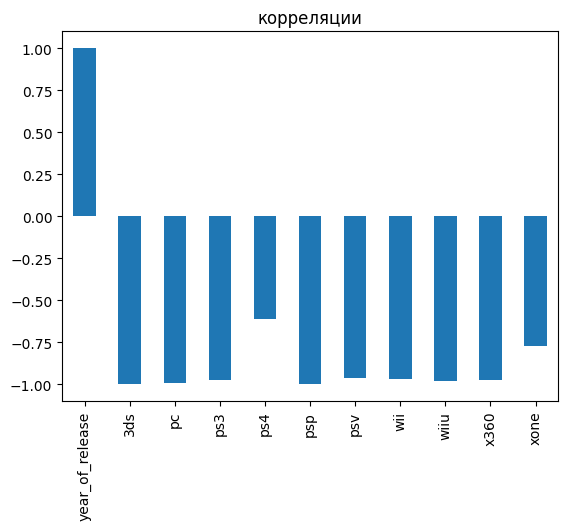

In [21]:
# Какие платформы лидируют по продажам, растут или падают?
# Выберите несколько потенциально прибыльных платформ.

# построим умную табличку
p_t = (good_data
       .pivot_table(index='year_of_release',
                            columns='platform',
                            values='total_sales',
                            aggfunc='sum')
       .reset_index()
      )
table =(good_data
       .pivot_table(index='platform',
                    values='total_sales',
                    aggfunc='sum')
       .reset_index()
       .sort_values(by='total_sales')
      )
chempions = table['platform'].tail(5).to_list()
# посчитаем корреляцию между годом и продажами по платформе
def calculate_dynamic(p_t: pd.DataFrame)->dict:
    """
    Находит корреляцию между продажами
    по платформе и годом
    """
    if 'year_of_release' not in set(p_t.columns):
        raise BaseException('heheh, impossible operation')
    cheker = {}
    for platform in p_t.columns:
        cheker[platform] = p_t[platform].corr(p_t['year_of_release'])
    logging.debug(cheker)
    return cheker

print('Чемпионы по продажам в последнее время ', chempions)

pd.Series(calculate_dynamic(p_t)).plot(kind='bar',
                                       title='корреляции')
plt.show();

# объявим победителей
leaders = []
for k, v in calculate_dynamic(p_t).items():
    if v >= 0:
        leaders.append(k)
    else:
        continue

logging.debug(leaders)


Такс, список чемпионов 'x360', 'ps3', '3ds', 'xone', 'ps4'; так как анализируемый период сократился, то в последнее время продажи все время падали, поэтому и коэффициент корреляции везде отрицательный

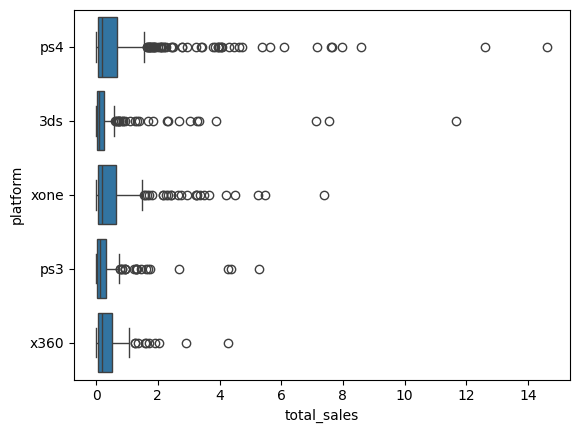

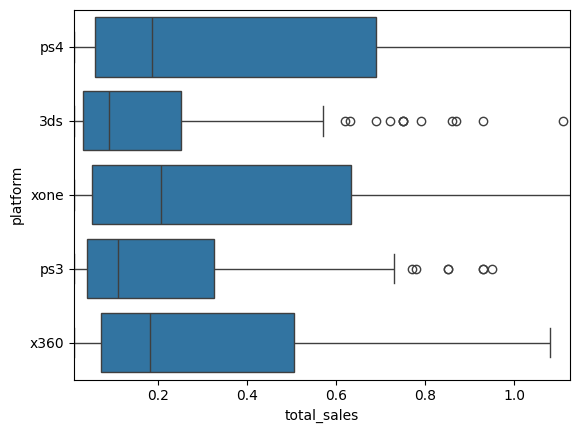

In [22]:
# Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
class BoxAnal:
    """
    Класс содержит анализ по выбросам
    """


    def __init__(self, df, column, factor):
        """
        активация...
        """
        self.df = df
        self.column = column
        self.factor = factor
        if column and factor not in set(df.columns):
            raise BaseException('ошибка при формировании класса')
        if self.df[self.column].isna().sum() > 0:
            raise BaseException('дурацкий numpy')

    @property
    def __metrix(self):
        """
        Рассчитываем показатели:
        -второй квартиль
        -третий квартиль
        -межквартильный размах
        """
        q75, q25 = np.percentile(self.df[self.column], [75 ,25])
        iqr = q75 - q25
        metrixs = {'iqr': iqr,
                   'q75': q75,
                   'q25': q25}
        return metrixs

    @property
    def midian(self):
        return self.df[self.column].median()

    @property
    def quentile_75(self):
        return self.__metrix['q75']

    @property
    def max_not_anom(self):
        """
        Вычисляет верхнюю границу усов
        """
        max_not_anom = self.__metrix['q75'] + 1.5*self.__metrix['iqr']
        if (max_not_anom > self.df[self.column].max()):
            return self.df[self.column].max()
        else:
            return max_not_anom

    @property
    def min_not_anom(self):
        """
        Вычисляет нижнюю границу усов
        """
        min_not_anom = self.__metrix['q25'] - 1.5*self.__metrix['iqr']
        if min_not_anom < self.df[self.column].min():
            return self.df[self.column].min()
        else:
            return min_not_anom

    @property
    def represantation(self):
        sns.boxplot(x=self.df[self.column], y=self.df[self.factor])
        plt.show();

    @property
    def represent_in_detail(self):
        sns.boxplot(x=self.df[self.column], y=self.df[self.factor]).set_xlim([self.min_not_anom, self.max_not_anom])
        plt.show();



df = good_data.query('platform in @chempions')

stat_leaders = BoxAnal(df=df, column='total_sales', factor='platform')

stat_ps4 = BoxAnal(df=df[df['platform'] == 'ps4'], column='total_sales', factor='platform')

stat_xone = BoxAnal(df=df[df['platform'] == 'xone'], column='total_sales', factor='platform')

stat_other = BoxAnal(df=good_data[(good_data['platform'] != 'ps4')&(good_data['platform'] != 'xone')], column='total_sales', factor='platform')

logging.debug(stat_other.max_not_anom)

stat_leaders.represantation
stat_leaders.represent_in_detail

2024-05-02 23:27:48,891 - INFO - Анал. по ps4


Верхняя граница усов 1.6387500000000002
Нижняя граница усов 0.01
медиана 0.185
75% квантиль 0.6900000000000001
Процент выбросов 3.137951450562463


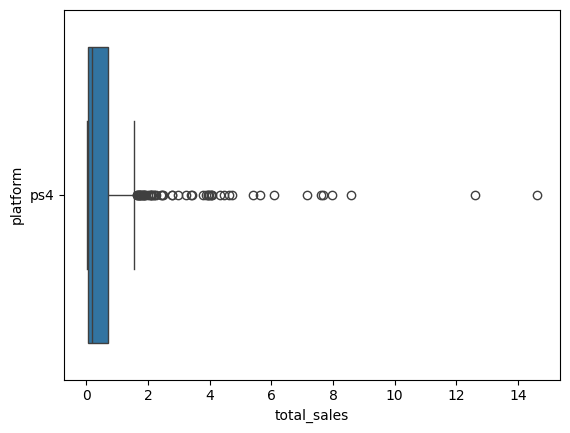

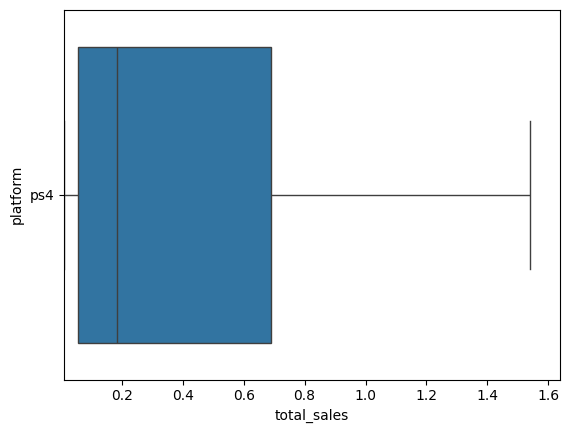

In [23]:
logging.info('Анал. по ps4')
print('Верхняя граница усов',stat_ps4.max_not_anom)
print('Нижняя граница усов',stat_ps4.min_not_anom)
print('медиана',stat_ps4.midian)
print('75% квантиль',stat_ps4.quentile_75)
print('Процент выбросов',len(good_data.query('platform =="ps4" and @stat_ps4.max_not_anom < total_sales or total_sales < @stat_ps4.min_not_anom'))/len(good_data)*100)
stat_ps4.represantation
stat_ps4.represent_in_detail


2024-05-02 23:27:49,484 - INFO - Анал. по xone


Верхняя граница усов 1.50625
Нижняя граница усов 0.01
медиана 0.205
75% квантиль 0.6325000000000001


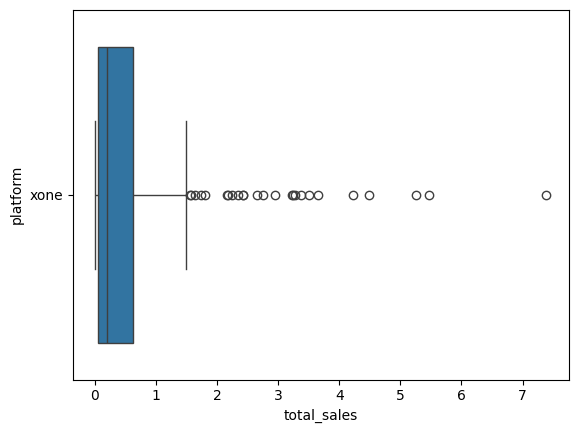

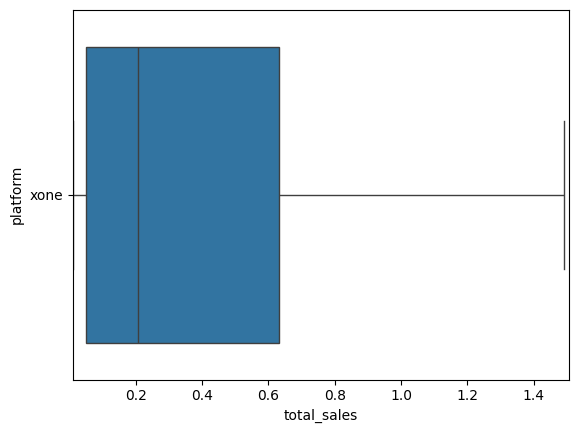

процент выбросов 1.3617525162818236


In [24]:
logging.info('Анал. по xone')
print('Верхняя граница усов',stat_xone.max_not_anom)
print('Нижняя граница усов',stat_xone.min_not_anom)
print('медиана',stat_xone.midian)
print('75% квантиль',stat_xone.quentile_75)
stat_xone.represantation
stat_xone.represent_in_detail
print('процент выбросов',len(good_data.query('platform =="xone" and @stat_ps4.max_not_anom < total_sales or total_sales < @stat_ps4.min_not_anom'))/len(good_data)*100)

2024-05-02 23:27:50,038 - INFO - Анал. по всем остальным


Верхняя граница усов 0.505
Нижняя граница усов 0.01
медиана 0.07
75% квантиль 0.22


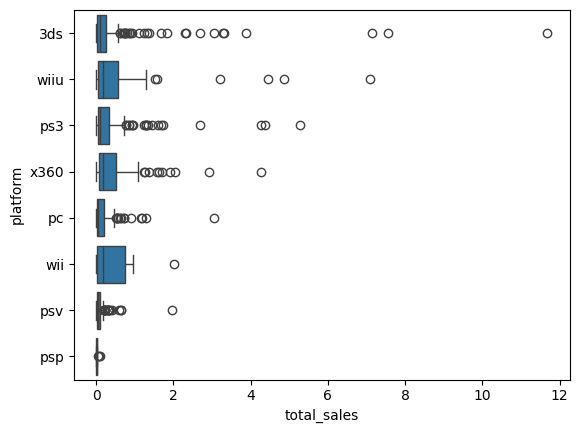

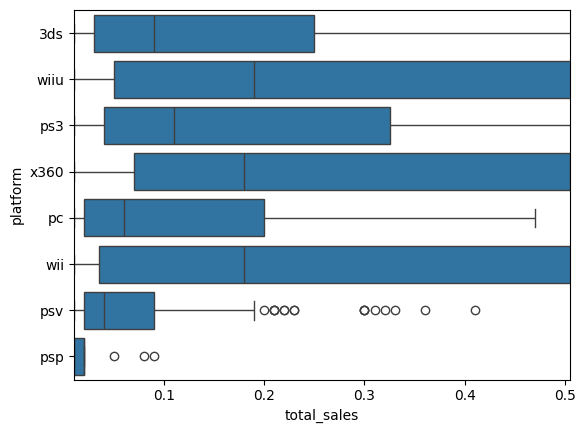

процент выбросов 1.7761989342806392


In [25]:
logging.info('Анал. по всем остальным')
print('Верхняя граница усов',stat_other.max_not_anom)
print('Нижняя граница усов',stat_other.min_not_anom)
print('медиана',stat_other.midian)
print('75% квантиль',stat_other.quentile_75)
stat_other.represantation
stat_other.represent_in_detail
print('процент выбросов',len(good_data.query('platform not in ["xone","ps4"] and @stat_ps4.max_not_anom < total_sales or total_sales < @stat_ps4.min_not_anom'))/len(good_data)*100)

Нижняя граница у всех одинаковая, самая большая верхняя у ps4, у него же больше всего выбросов, xone - в этом плане радует

2024-05-02 23:27:50,572 - INFO - 0.3676072771129054


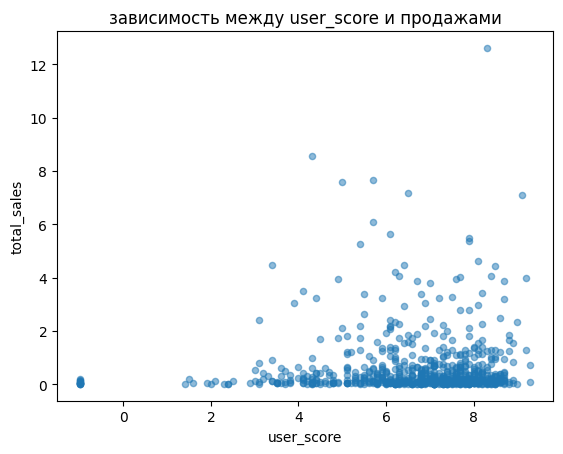

0.04484385050459479


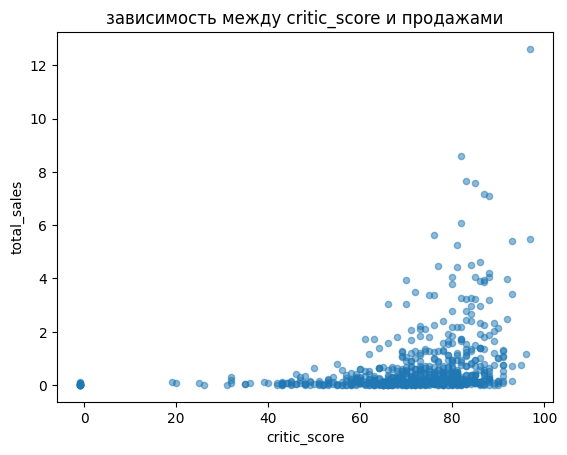

0.2958512503256782


In [26]:
# Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
# Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.
# Сформулируйте выводы.

# сделаем рисуночек по xone - он там, в последнее время активнее всех рос
def make_funy_corr(platform):
    df = good_data[(good_data['platform']== platform) & (good_data['user_score'] != -1) | (good_data['critic_score'] != -1)]
    logging.info(df['user_score'].corr(df['critic_score']))
    for _ in ['user_score', 'critic_score']:
        df.plot(kind='scatter',
                x=_,
                y='total_sales',
                alpha=0.5,
                title=f'зависимость между {_} и продажами')
        plt.show();
        print(df[_].corr(df['total_sales']))
make_funy_corr('xone')

2024-05-02 23:27:51,069 - INFO - -0.0703839280647581
2024-05-02 23:27:51,071 - INFO - 0.42867694370333226


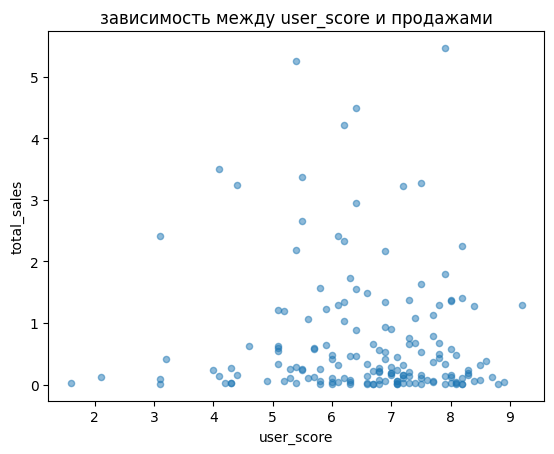

-0.0703839280647581


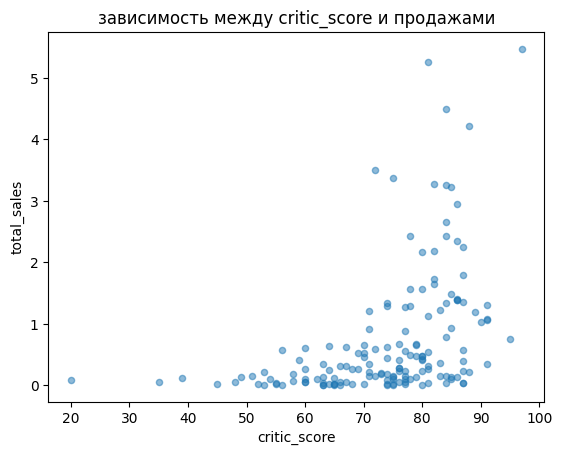

0.42867694370333226


In [27]:
def make_funy_corr(platform):
    user_data = good_data[(good_data['platform']== platform) & (good_data['user_score'] != -1)]
    critic_data = good_data[(good_data['platform']== platform) & (good_data['critic_score'] != -1)]
    logging.info(user_data['user_score'].corr(user_data['total_sales']))
    logging.info(critic_data['critic_score'].corr(critic_data['total_sales']))
    for data, score_type in zip([user_data, critic_data], ['user_score', 'critic_score']):
        data.plot(kind='scatter',
                  x=score_type,
                  y='total_sales',
                  alpha=0.5,
                  title=f'зависимость между {score_type} и продажами')
        plt.show()
        print(data[score_type].corr(data['total_sales']))


make_funy_corr('xone')

In [28]:
# Соотнесите выводы с продажами игр на других платформах.
relation_score = {} 
 
for platform in good_data['platform'].unique(): 
    user_data = good_data[(good_data['platform']== platform) & (good_data['user_score'] != -1)]
    critic_data = good_data[(good_data['platform']== platform) & (good_data['critic_score'] != -1)]
    relation_score[platform] = [user_data['user_score'].corr(critic_data['critic_score'])]

for _ in ['user_score', 'critic_score']: 
    for platform in good_data['platform'].unique(): 
        data = good_data[(good_data['platform']== platform) & (good_data[_] != -1)] 
        relation_score[platform].append(data[_].corr(data['total_sales'])) 
    

df_2 = pd.DataFrame(data=relation_score, index=['user_critic', 'user_sales', 'critic_sales']).style.background_gradient('coolwarm')
df_2

,ps4,3ds,xone,wiiu,ps3,x360,pc,wii,psv,psp
user_critic,0.546434,0.862485,0.440977,0.763536,0.693445,0.625309,0.466099,nan,0.524066,nan
user_sales,-0.040132,0.215193,-0.070384,0.407926,-0.166761,-0.138445,-0.071597,1.000000,-0.168455,nan
critic_sales,0.402661,0.314117,0.428677,0.370201,0.446575,0.525723,0.174634,nan,0.042665,nan


2024-05-02 23:27:51,937 - INFO - -0.040131589472697356
2024-05-02 23:27:51,939 - INFO - 0.40266141068104083


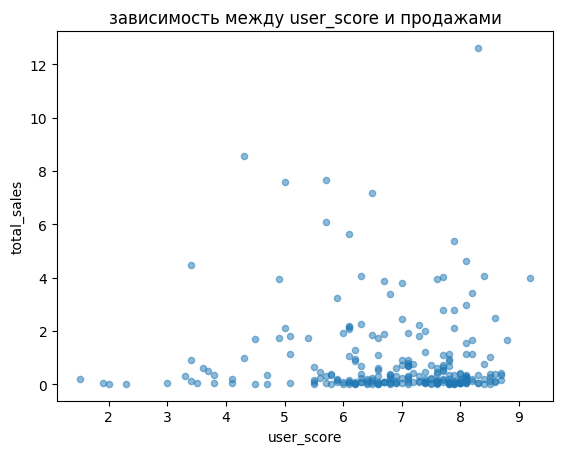

-0.040131589472697356


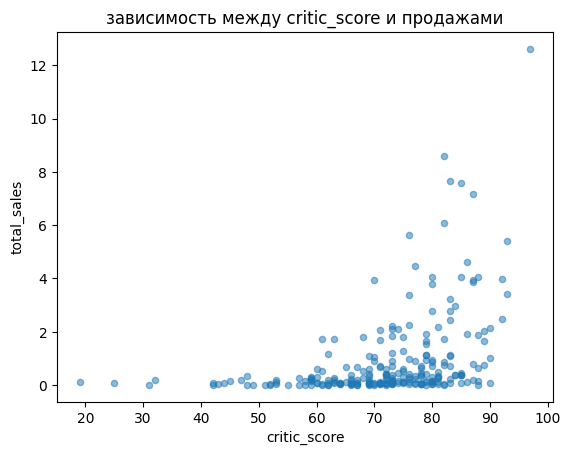

0.40266141068104083


In [29]:
make_funy_corr('ps4')

2024-05-02 23:27:52,419 - INFO - -0.16676141347662118
2024-05-02 23:27:52,422 - INFO - 0.44657460493190704


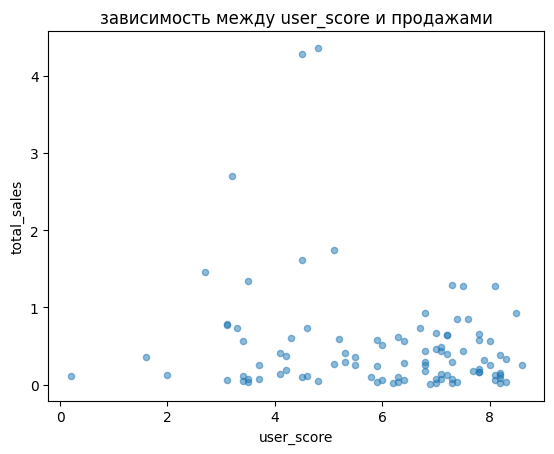

-0.16676141347662118


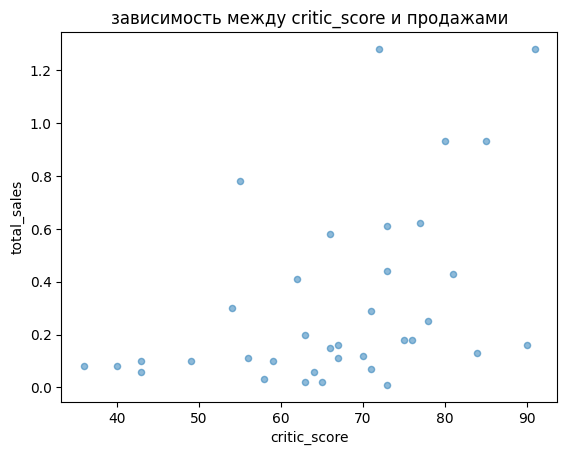

0.44657460493190704


In [30]:
make_funy_corr('ps3')

Видно, что положительная корреляция между отзывами критиков и пользователями существует.
Нет корреляции между отзывами пользователей и продажами.
Очень слабая корреляция между отзывами критиков и продажами

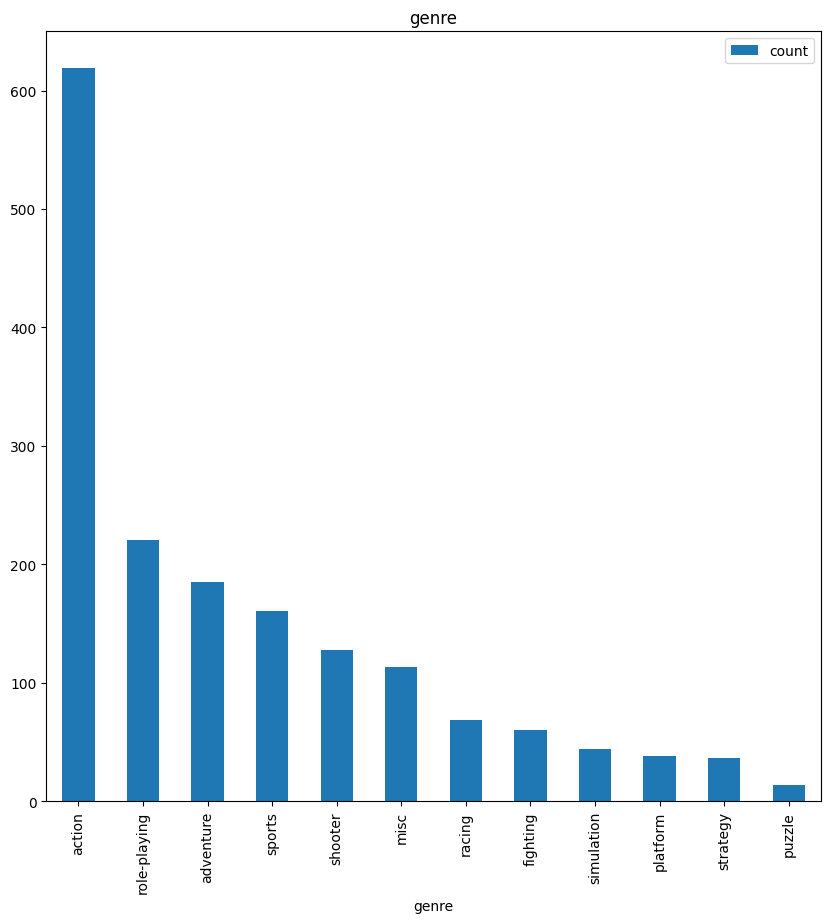

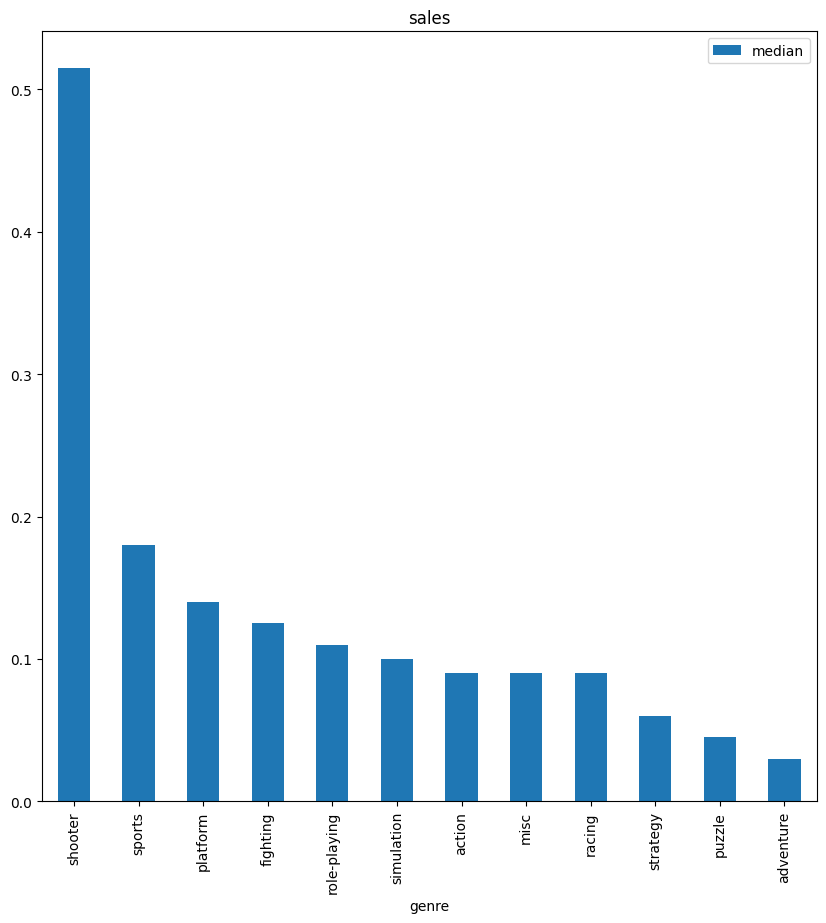

In [31]:
# Посмотрите на общее распределение игр по жанрам.
# Что можно сказать о самых прибыльных жанрах? 
# Выделяются ли жанры с высокими и низкими продажами?

p_t = good_data.pivot_table(index='genre',
                           values='name',
                           aggfunc='count')
p_t.columns = ['count']
p_t = p_t.sort_values(by='count', 
                      ascending=False)
p_t.plot(kind='bar',
         figsize=(10,10),
         title='genre');


p_t = good_data.pivot_table(index='genre',
                           values='total_sales',
                           aggfunc='median')
p_t.columns = ['median']
p_t = p_t.sort_values(by='median',
                      ascending=False)
p_t.plot(kind='bar',
         figsize=(10,10),
         title='sales');

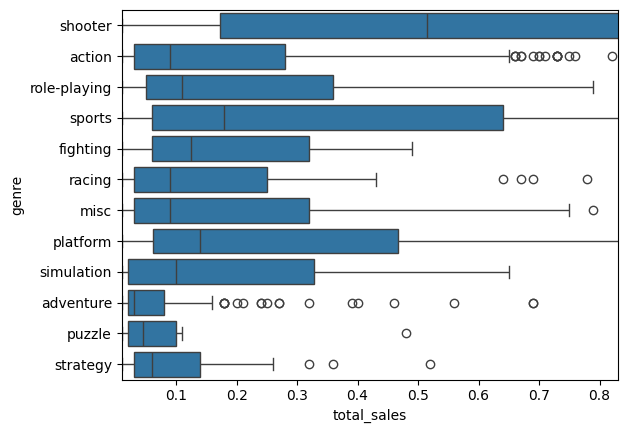

In [32]:
genre_box = BoxAnal(good_data, 'total_sales', 'genre')
genre_box.represent_in_detail

Можно заметить, что я был неправ, наиболее прибыльным является shooter - и значительно опережает все остальные, а action - несмотря на кол-во плетется в конце))

In [33]:
# Определите для пользователя каждого региона (NA, EU, JP):
# Самые популярные платформы (топ-5). Опишите различия в долях продаж.
# Самые популярные жанры (топ-5). Поясните разницу.
# Влияет ли рейтинг ESRB на продажи в отдельном регионе?

class Portret:
    def __init__(self, column):
        self.column = column

    @property
    def __tables(self):
        tables = []
        for _ in ['platform', 'genre', 'rating']:
            data = (good_data
                         .pivot_table(index=_,
                                      values=self.column,
                                      aggfunc='median')
                         .sort_values(by=self.column,
                                      ascending=False)
                         .reset_index())
            tables.append(data)
        return tables

    @property
    def top_5_platforms(self):
        self.__tables[0].plot(kind='bar', x='platform')
        plt.show();
        percent = self.__tables[0].loc[:4,[self.column]].sum()/self.__tables[0][self.column].sum()
        return [self.__tables[0]['platform'].head(5).to_list(), percent]

    @property
    def top_5_genres(self):
        self.__tables[1].plot(kind='bar', x='genre')
        plt.show();
        percent = self.__tables[1].loc[:4, [self.column]].sum()/self.__tables[1][self.column].sum()
        return [self.__tables[1]['genre'].head(5).to_list(), percent]

    @property
    def diagram(self):
        logging.debug(self.__tables[2])
        plt.bar(x=self.__tables[2]['rating'], height=self.__tables[2][self.column])
        plt.show();
        
NA = Portret(column='na_sales')
EU = Portret(column='eu_sales')
JP = Portret(column='jp_sales')

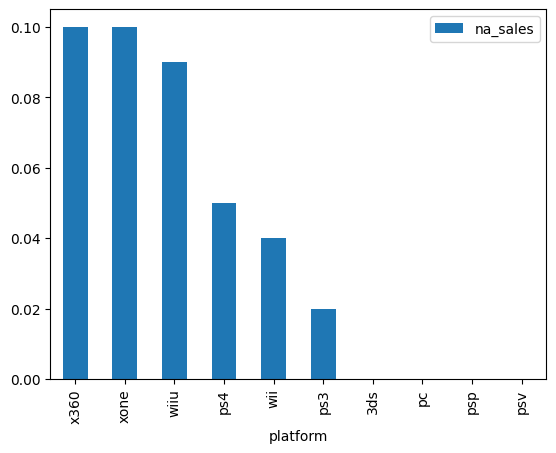

[['x360', 'xone', 'wiiu', 'ps4', 'wii'], na_sales    0.95
dtype: float64]


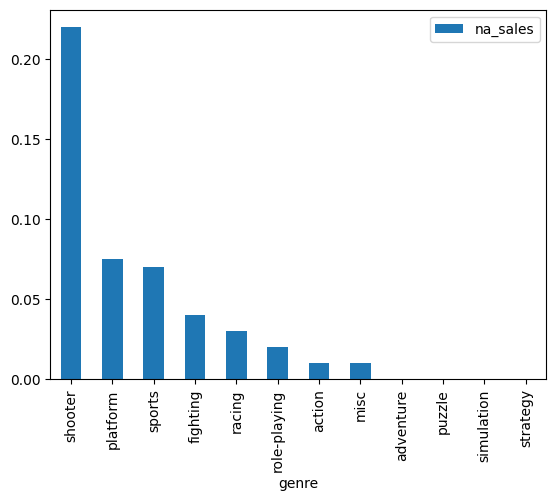

[['shooter', 'platform', 'sports', 'fighting', 'racing'], na_sales    0.915789
dtype: float64]


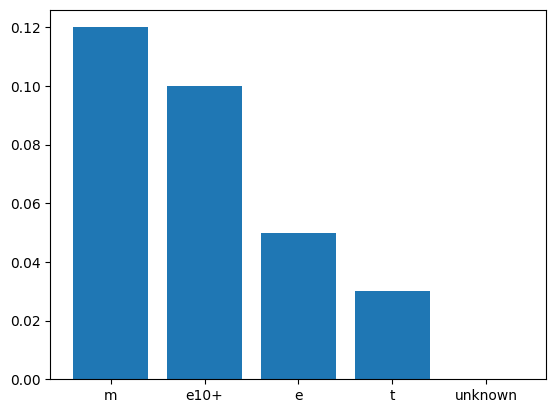

In [34]:
print(NA.top_5_platforms)
print(NA.top_5_genres)
NA.diagram

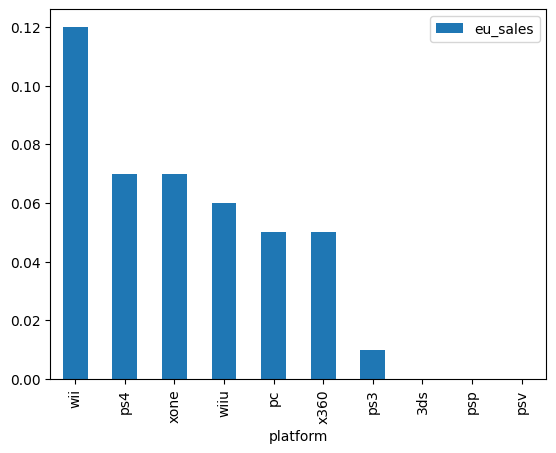

[['wii', 'ps4', 'xone', 'wiiu', 'pc'], eu_sales    0.860465
dtype: float64]


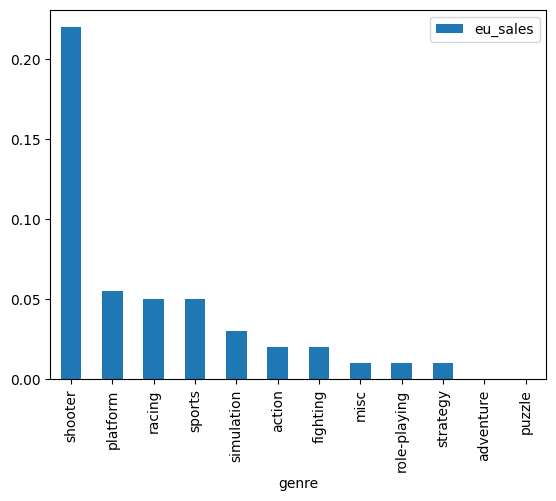

[['shooter', 'platform', 'racing', 'sports', 'simulation'], eu_sales    0.852632
dtype: float64]


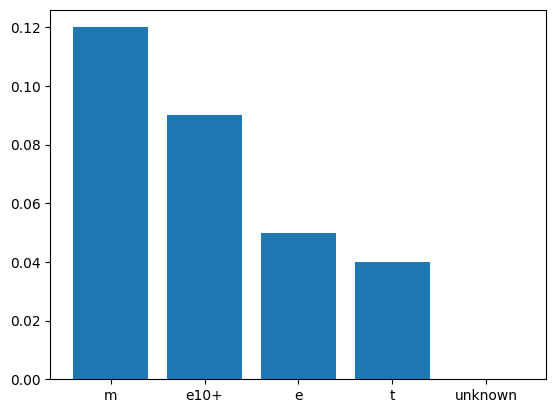

In [35]:
print(EU.top_5_platforms)
print(EU.top_5_genres)
EU.diagram

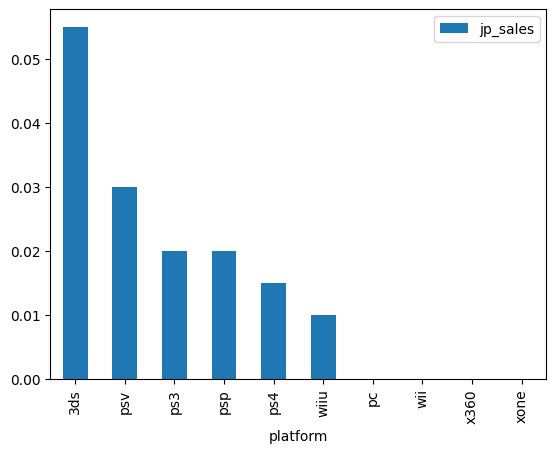

[['3ds', 'psv', 'ps3', 'psp', 'ps4'], jp_sales    0.933333
dtype: float64]


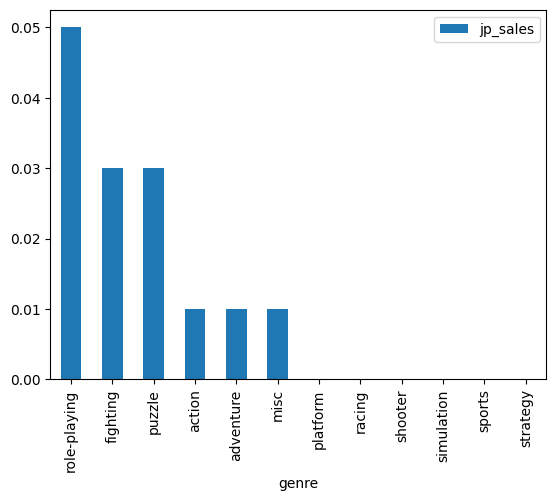

[['role-playing', 'fighting', 'puzzle', 'action', 'adventure'], jp_sales    0.928571
dtype: float64]


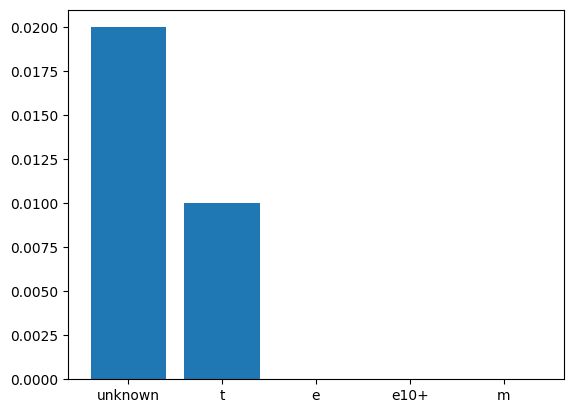

In [36]:
print(JP.top_5_platforms)
print(JP.top_5_genres)
JP.diagram

<p><i>Portret</i></p>
<p>В Северной Америке</p>
<p>Платформы : 'x360', 'xone', 'wiiu', 'ps4', 'wii' – самые популярные и составляют 0.95 всех продаж</p>
<p>Жанры: 'shooter', 'platform', 'sports', 'fighting', 'racing'– самые популярные и составляют 0.915789 всех продаж</p>

<p>Европа:</p>
<p>Платформы:  'wii', 'ps4', 'xone', 'wiiu', 'pc' – самые популярные и составляют 0.860465 всех продаж</p>
<p>Жанры : 'shooter', 'platform', 'racing', 'sports', 'simulation' – самые популярные и составляют 0.852632 всех продаж</p>
<p>Япония</p>
<p>Платформы:  '3ds', 'psv', 'ps3', 'psp', 'ps4'– самые популярные и составляют 0.83 всех продаж</p>
<p>Жанры : 'role-playing', 'fighting', 'puzzle', 'action', 'adventure' – самые популярные и составляют 0.928571 всех продаж</p>
<p>Распределение продаж по рейтингу в Японии отличается от Америки и Европы, там предпочитают игры без рейтинга</p>


<h1>Проверка гипотез</h1>

In [37]:
def calc_hypotese(data_1, data_2):
    results = st.ttest_ind(data_1,
                           data_2,
                           equal_var=False)
    alpha = 0.05
    print(results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

<p>H_0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые`</p>
<p>H_1: Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые`</p>
<p>alpha = 0.05</p>

In [38]:
data_1 = good_data.query('platform == "xone" and user_score != -1')['user_score']
data_2 = good_data.query('platform == "pc" and user_score != -1')['user_score']
calc_hypotese(data_1, data_2)

0.11601398086668835
Не получилось отвергнуть нулевую гипотезу


<p>H_0: Средние пользовательские рейтинги жанров Action и Sports одинаковые`</p>
<p>H_1: Средние пользовательские рейтинги жанров Action и Sports разные`</p>
<p>alpha = 0.05</p>

In [39]:
data_1 = good_data.query('genre == "action" and user_score != -1')['user_score']
data_2 = good_data.query('genre == "sports" and user_score != -1')['user_score']
calc_hypotese(data_1, data_2)

1.1825550382644557e-14
Отвергаем нулевую гипотезу


<h1>Вывод</h1>

<p>Отрасаль пошла на спад</p>
<p>В результате исследования были выявлены самые популярные платформы и жанры в мире и в Японии, а также отмечено различие в распределении продаж по рейтингу в Японии от Америки и Европы. Полученные результаты могут быть использованы для планирования рекламных кампаний и выбора потенциально популярных продуктов.</p>
<p> Выявлены корреляционные зависимости междуотзывами пользователей и критиков и их влияние на продажи</p>
<p>Видно, что положительная корреляция между отзывами критиков и пользователями существует</p>
<p>Нет корреляции между отзывами пользователей и продажами</p>
<p>Очень слабая корреляция между отзывами критиков и продажами</p>

<p> Стоит внимательно определять целевую группу покупателей, так как от этого сильно меняются предпочтения в жанрах и платформах </p>

<p>  В целом, стоит обратить внимание на xone, у них неплохие показатели везде</p>

